In [1]:
import hail as hl
hl.init()

Running on Apache Spark version 2.4.1
SparkUI available at http://10.151.37.234:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.28-61941242c15d
LOGGING: writing to /Users/yanyul/Documents/repo/github/simulate-phenotype-for-1kg/notebook/hail-20191211-1404-0.2.28-61941242c15d.log


In [2]:
import os
from hail.plot import show
from pprint import pprint
from IPython.display import display
hl.plot.output_notebook()

Loading BokehJS ...

Download 1000G data using hail built-in function.

In [3]:
hl.utils.get_1kg('data/')

2019-12-11 14:04:39 Hail: INFO: 1KG files found


Read in the downloaded VCF file and write into MatrixTable format.

In [4]:
hl.import_vcf('data/1kg.vcf.bgz').write('data/1kg.mt', overwrite = True)

2019-12-11 14:04:41 Hail: INFO: Coerced sorted dataset
2019-12-11 14:04:44 Hail: INFO: wrote matrix table with 10961 rows and 284 columns in 2 partitions to data/1kg.mt


In [5]:
mt = hl.read_matrix_table('data/1kg.mt')

Quick look at the genotype matrix.

In [6]:
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    }
----------------------------------------
Entry fields:
    'GT': call
    'AD': array<int32>
    'DP': int32
    'GQ': int32
    'PL': array<int32>
----------------------------------------
Colu

Simulate effect sizes for N traits and simulate K covariates.

In [7]:
Ntrait = 20
Kcovar = 5
frac_causal_high = 0.02
frac_causal_low = 0.0005
nsnp = mt.count_rows()
nindiv = mt.count_cols()
snp_locus = mt.locus.collect()
snp_allele = mt.alleles.collect()
indiv_id = mt.s.collect()

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Let's define a function giving out simulated beta's and covariates 

In [9]:
def simulate_vector(length, frac_causal_range = None):
    if frac_causal_range is not None:
        frac_causal_low = min(frac_causal_range)
        frac_causal_high = max(frac_causal_range)
        ncausal = int(np.random.uniform(low = frac_causal_low, high = frac_causal_high, size = 1) * length)
    else:
        ncausal = length    
    nonzero_betas = np.random.uniform(low = -1, high = 1, size = ncausal)
    nonzero_idx = np.random.choice(range(length), size = ncausal, replace = False)
    betas = np.zeros([length])
    betas[nonzero_idx] = nonzero_betas
    plt = sns.scatterplot(x = range(length), y = betas)
    return betas, plt

OK, let's simulate both $\beta$'s and covariates

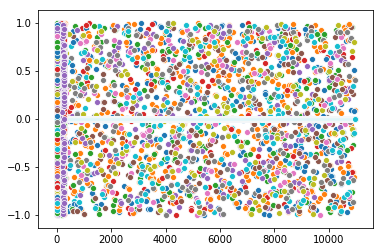

In [10]:
# for betas, it is by snp
effect_dic = {}
for i in range(Ntrait):
    trait_name = f'trait_{i}'
    effect_dic[trait_name] = simulate_vector(nsnp, [frac_causal_low, frac_causal_high])[0]
effect_dic['locus'] = snp_locus
effect_dic['allele'] = snp_allele
df_effect = pd.DataFrame(effect_dic)

# for covariate, it loops over covariates
covar_dic = {}
for i in range(Kcovar):
    covar_name = f'covar_{i}'
    covar_dic[covar_name] = simulate_vector(nindiv)[0]
covar_dic['s'] = indiv_id
df_covar = pd.DataFrame(covar_dic)

# also, effect size of covariates for each trait
covar_eff_dic = {}
covar_eff_dic['covar_name'] = [ f'covar_{j}' for j in range(Kcovar) ]
for i in range(Ntrait):
    trait_name = f'trait_{i}'
    covar_eff_dic[trait_name] = simulate_vector(Kcovar)[0]
df_covar_eff = pd.DataFrame(covar_eff_dic)

# also, intercept of each trait
intercept_dic = {}
for i in range(Ntrait):
    trait_name = f'trait_{i}'
    intercept_dic[trait_name] = simulate_vector(1)[0]
df_intercept = pd.DataFrame(intercept_dic)
        
        

In [11]:
display(df_effect)
display(df_covar)
display(df_covar_eff)
display(df_intercept)

,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,...,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19,locus,allele
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1:904165,"[G, A]"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1:909917,"[G, A]"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1:986963,"[C, T]"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1:1563691,"[T, G]"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1:1707740,"[T, G]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,X:152660491,"[C, G]"
10957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.403279,0.0,0.0,X:153031688,"[C, T]"
10958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,X:153674876,"[C, T]"
10959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,X:153706320,"[C, T]"


,covar_0,covar_1,covar_2,covar_3,covar_4,s
0,-0.478800,-0.542758,0.772391,0.675793,0.494673,HG00096
1,-0.098921,0.099104,0.566994,0.892098,0.921801,HG00099
2,0.798860,0.326325,-0.610330,0.309924,-0.556479,HG00105
3,0.672223,-0.758295,-0.355517,-0.200377,0.927060,HG00118
4,-0.223710,0.244835,-0.472760,0.548340,-0.068017,HG00129
...,...,...,...,...,...,...
279,0.785294,0.313535,0.420155,0.469379,0.572723,NA21114
280,-0.564577,0.642022,0.204934,-0.501465,-0.876147,NA21116
281,-0.142152,0.472213,-0.300271,-0.988937,-0.396803,NA21118
282,0.759162,0.176182,0.324818,-0.242950,-0.315068,NA21133


,covar_name,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,...,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19
0,covar_0,0.572334,0.045432,0.796325,0.596057,0.269679,-0.828291,0.730540,0.357532,-0.355784,...,0.147583,-0.577112,0.381206,0.633591,-0.114503,-0.814970,0.174640,0.277313,-0.476344,-0.844523
1,covar_1,-0.700819,0.427132,0.155447,0.343607,-0.620708,0.803714,-0.604715,-0.979917,-0.567765,...,0.741199,-0.229215,0.124490,-0.743714,-0.947050,0.652429,-0.542834,-0.716507,-0.668219,-0.714891
2,covar_2,0.740361,-0.722574,-0.380092,-0.763358,-0.364637,-0.819555,0.442769,0.521238,-0.295842,...,0.248168,-0.473584,-0.264660,0.866860,-0.879405,0.695020,-0.455298,-0.386839,-0.336352,0.110364
3,covar_3,0.481673,-0.414418,-0.567866,0.914254,0.543555,0.926454,0.483260,-0.061480,-0.300092,...,0.245661,-0.415536,0.705892,-0.240414,0.003226,0.030526,-0.250941,-0.167090,-0.212823,-0.456894
4,covar_4,-0.894742,-0.435353,-0.657535,-0.283937,-0.462111,0.977789,0.452420,0.799132,-0.423524,...,0.517551,0.719322,-0.711192,0.755063,-0.294919,0.224870,-0.909209,-0.448335,0.371065,0.950937


,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19
0,0.278585,0.415416,0.47136,0.260948,-0.879309,-0.696691,-0.158978,0.750375,0.524593,0.370954,0.094193,0.86499,-0.036628,-0.713499,-0.311207,0.410758,-0.55811,-0.157081,-0.706685,-0.590103


Now, let's compute effect of covariates on each trait and each individual.
To do so, let's convert these effect size and covariates data frames to hail format `Table` and `MatrixTable`.
Basically, we'd like to do: 
* We have `indiv x covar` matrix and `covar x trait` matrix
* For each individual, multiply covariate with the covariate effect size and add them up
* It means Einstein summation aggregating over covar

In [12]:
# convert indiv x covar to MatrixTable
# if not os.path.exists('output/indiv_covar.mt'):
(hl.Table
 .from_pandas(pd.melt(df_covar, id_vars=['s']).rename(columns = {'variable' : 'covar'}))
 .to_matrix_table(row_key = ['s'], col_key = ['covar'])
).write('output/indiv_covar.mt', overwrite = True)
indiv_covar = hl.read_matrix_table('output/indiv_covar.mt')
display(indiv_covar.describe())

# convert covar x trait to Table
# if not os.path.exists('output/covar_trait.ht'):
(hl.Table
.from_pandas(df_covar_eff.rename(columns = {'covar_name' : 'covar'}), key = ['covar'])  # pd.melt(df_covar_eff, id_vars=['covar_name']).rename(columns = {'covar_name' : 'covar', 'variable' : 'trait'}))
#     .to()
).write('output/covar_trait.ht', overwrite = True)
covar_trait = hl.read_table('output/covar_trait.ht')
display(covar_trait.describe())

2019-12-11 14:04:52 Hail: INFO: Ordering unsorted dataset with network shuffle


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'covar': str
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'value': float64
----------------------------------------
Column key: ['covar']
Row key: ['s']
----------------------------------------


2019-12-11 14:04:52 Hail: INFO: wrote matrix table with 284 rows and 5 columns in 8 partitions to output/indiv_covar.mt


None

2019-12-11 14:04:53 Hail: INFO: Coerced sorted dataset


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'covar': str 
    'trait_0': float64 
    'trait_1': float64 
    'trait_2': float64 
    'trait_3': float64 
    'trait_4': float64 
    'trait_5': float64 
    'trait_6': float64 
    'trait_7': float64 
    'trait_8': float64 
    'trait_9': float64 
    'trait_10': float64 
    'trait_11': float64 
    'trait_12': float64 
    'trait_13': float64 
    'trait_14': float64 
    'trait_15': float64 
    'trait_16': float64 
    'trait_17': float64 
    'trait_18': float64 
    'trait_19': float64 
----------------------------------------
Key: ['covar']
----------------------------------------


2019-12-11 14:04:53 Hail: INFO: wrote table with 5 rows in 5 partitions to output/covar_trait.ht


None

In [13]:
# ok, let's do the calculation
# 1. annotate indiv x covar with trait effect size
# 2. aggregate 
indiv_covar = indiv_covar.annotate_cols(trait_agg = covar_trait[indiv_covar.covar])
indiv_covar.describe()
indiv_covar.entry.show()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'covar': str
    'trait_agg': struct {
        trait_0: float64, 
        trait_1: float64, 
        trait_2: float64, 
        trait_3: float64, 
        trait_4: float64, 
        trait_5: float64, 
        trait_6: float64, 
        trait_7: float64, 
        trait_8: float64, 
        trait_9: float64, 
        trait_10: float64, 
        trait_11: float64, 
        trait_12: float64, 
        trait_13: float64, 
        trait_14: float64, 
        trait_15: float64, 
        trait_16: float64, 
        trait_17: float64, 
        trait_18: float64, 
        trait_19: float64
    }
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'value': float64
----------------------------------------
Column key: ['covar']
Row key: ['s']
----------------------------------------


s,covar_0.value,covar_1.value,covar_2.value,covar_3.value,covar_4.value
str,float64,float64,float64,float64,float64
"""HG00096""",-4.79e-01,-5.43e-01,7.72e-01,6.76e-01,4.95e-01
"""HG00099""",-9.89e-02,9.91e-02,5.67e-01,8.92e-01,9.22e-01
"""HG00105""",7.99e-01,3.26e-01,-6.10e-01,3.10e-01,-5.56e-01
"""HG00118""",6.72e-01,-7.58e-01,-3.56e-01,-2.00e-01,9.27e-01
"""HG00129""",-2.24e-01,2.45e-01,-4.73e-01,5.48e-01,-6.80e-02
"""HG00148""",7.76e-01,7.65e-02,2.93e-01,-5.84e-01,-1.80e-01
"""HG00177""",3.76e-01,-2.90e-01,-5.62e-01,6.74e-01,7.88e-01
"""HG00182""",-5.16e-01,-8.76e-01,9.32e-01,-6.06e-01,4.62e-01
"""HG00242""",-9.72e-01,-9.90e-01,5.43e-01,5.58e-01,8.26e-01


In [14]:
expr_ = {
    k : hl.agg.sum(indiv_covar.trait_agg[k] * indiv_covar.value)
    for k in list(indiv_covar.trait_agg.keys())
}
indiv_covar = indiv_covar.annotate_rows(**expr_)

In [15]:
indiv_idx = 10
trait_idx = 20
this_re = indiv_covar.rows().to_pandas().iloc[[indiv_idx - 1], [trait_idx]]
print('sanity check')
a = df_covar_eff.iloc[:, [trait_idx]]
b = df_covar.iloc[[indiv_idx - 1], : (df_covar.shape[1] - 1)]
alter_re = np.sum(np.array(b) * np.array(a).transpose())
print('if this == alter ? ', this_re.to_numpy() == alter_re)

sanity check
if this == alter ?  [[ True]]


OK, it works. Now that we need to repeat the similar procedure to compute the genetic effect. 
Let's organize what we have and see how we can do it.
* We have `snp x trait` matrix and `snp x indiv` matrix
* We can annotate rows of `snp x indiv` with effect size of SNPs
* And then, do the calculation

In [16]:
df_effect['new'] = df_effect[['locus', 'allele']].apply(lambda x: str(x[0]) + ':' + x[1][0] + ':' + x[1][1], axis = 1)

In [17]:
# convert snp x trait matrix to Table 
# I got a hard time using from_pandas so that I did the work around as follow
df_effect.to_csv('output/snp_trait.tsv', sep = '\t', index = False)
tdic = { f'trait_{i}' : hl.tfloat for i in range(Ntrait) }
snp_trait = hl.import_table('output/snp_trait.tsv', types = tdic)
# some ugly formatting
snp_trait_new = snp_trait.annotate(a = hl.parse_variant(snp_trait.new))
snp_trait_new = snp_trait_new.drop('locus', 'allele', 'new')
snp_trait_new = snp_trait_new.flatten().rename({'a.locus': 'locus', 'a.alleles' : 'alleles'})
snp_trait = snp_trait_new
snp_trait = snp_trait.key_by(snp_trait.locus, snp_trait.alleles)
snp_trait.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'trait_0': float64 
    'trait_1': float64 
    'trait_2': float64 
    'trait_3': float64 
    'trait_4': float64 
    'trait_5': float64 
    'trait_6': float64 
    'trait_7': float64 
    'trait_8': float64 
    'trait_9': float64 
    'trait_10': float64 
    'trait_11': float64 
    'trait_12': float64 
    'trait_13': float64 
    'trait_14': float64 
    'trait_15': float64 
    'trait_16': float64 
    'trait_17': float64 
    'trait_18': float64 
    'trait_19': float64 
    'locus': locus<GRCh37> 
    'alleles': array<str> 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


2019-12-11 14:05:03 Hail: INFO: Reading table with no type imputation
  Loading column 'trait_0' as type 'float64' (user-specified)
  Loading column 'trait_1' as type 'float64' (user-specified)
  Loading column 'trait_2' as type 'float64' (user-specified)
  Loading column 'trait_3' as type 'float64' (user-specified)
  Loading column 'trait_4' as type 'float64' (user-specified)
  Loading column 'trait_5' as type 'float64' (user-specified)
  Loading column 'trait_6' as type 'float64' (user-specified)
  Loading column 'trait_7' as type 'float64' (user-specified)
  Loading column 'trait_8' as type 'float64' (user-specified)
  Loading column 'trait_9' as type 'float64' (user-specified)
  Loading column 'trait_10' as type 'float64' (user-specified)
  Loading column 'trait_11' as type 'float64' (user-specified)
  Loading column 'trait_12' as type 'float64' (user-specified)
  Loading column 'trait_13' as type 'float64' (user-specified)
  Loading column 'trait_14' as type 'float64' (user-specif

In [18]:
mt = mt.annotate_rows(genetic_eff = snp_trait[mt.locus, mt.alleles])
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    }
    'genetic_eff': struct {
        trait_0: float64, 
        trait_1: float64, 
        trait_2: float64, 
        trait_3: float64, 
        trait_4: float64, 
        trait_5: float64, 
   

In [19]:
expr_ = {
    k : hl.agg.sum(mt.genetic_eff[k] * mt.GT.n_alt_alleles())
    for k in list(mt.genetic_eff.keys())
}

In [23]:
mt = mt.annotate_cols(**expr_)

Now that we have both genetic effect and covariates effect by individuals. 

In [31]:
display(indiv_covar.row.show(3))
display(mt.col.show(3))

s,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19
str,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""HG00096""",5.61e-01,-1.31e+00,-1.47e+00,-5.84e-01,6.49e-02,4.37e-01,8.71e-01,1.12e+00,-1.62e-01,1.12e+00,1.41e-01,1.10e-01,-3.29e-01,9.81e-01,-2.54e-01,7.05e-01,-7.60e-01,-3.77e-01,3.71e-01,1.04e+00
"""HG00099""",-1.01e-01,-1.14e+00,-1.39e+00,9.61e-02,-2.36e-01,1.42e+00,9.67e-01,8.45e-01,-8.47e-01,6.36e-01,8.96e-01,5.82e-02,-2.01e-01,8.37e-01,-8.50e-01,7.74e-01,-1.39e+00,-8.80e-01,-5.76e-02,5.44e-01
"""HG00105""",4.24e-01,7.31e-01,1.11e+00,1.50e+00,6.61e-01,-1.56e-01,1.40e-02,-8.16e-01,-1.46e-01,-5.03e-01,-3.56e-03,-7.76e-01,1.12e+00,-7.60e-01,3.01e-01,-9.78e-01,6.68e-01,4.22e-01,-6.66e-01,-1.65e+00


None

2019-12-11 14:10:33 Hail: INFO: Coerced sorted dataset


s,trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19
str,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""HG00096""",2.30e+00,3.30e+00,4.78e+00,3.20e+00,-2.59e+00,-1.54e+00,-6.78e+00,-2.14e-01,5.45e-01,8.47e+00,-6.43e+00,5.40e+00,6.26e+00,-1.93e+00,9.60e+00,-4.35e+00,8.68e+00,7.92e+00,4.36e+00,2.80e+00
"""HG00099""",-3.18e+00,-2.00e+00,5.94e+00,5.92e+00,-2.77e+00,-6.11e+00,-4.53e+00,-2.50e+00,6.85e-01,1.02e+01,1.73e+00,1.95e+00,6.62e+00,1.52e+00,1.24e+01,3.57e+00,3.78e+00,8.03e+00,6.82e+00,2.26e+00
"""HG00105""",2.78e+00,5.46e-01,4.88e-01,5.14e+00,-6.10e+00,-6.48e+00,-2.42e+00,2.38e-01,3.10e-01,1.04e+01,5.83e+00,7.12e+00,8.10e+00,7.13e-01,8.43e-01,1.69e+00,1.18e+01,1.10e+01,5.39e+00,4.86e+00


None

The missing ingrediant is to for the intercept table.

In [51]:
# df_intercept.transpose()
tmp = list(df_intercept.transpose().index)
df_intercept = df_intercept.transpose()
df_intercept['trait'] = tmp
# df_intercept.set_index('dd').T
# hl.Table.from_pandas().show()

In [63]:
df_intercept = df_intercept.rename(columns = {0 : 'intercept'})

In [73]:
display(df_intercept.head())
hl.Table.from_pandas(df_intercept, key = ['trait']).write('output/trait_intercept.ht', overwrite = True)
trait_intercept = hl.read_table('output/trait_intercept.ht')
trait_intercept.describe()

,intercept,trait
trait_0,0.278585,trait_0
trait_1,0.415416,trait_1
trait_2,0.471360,trait_2
trait_3,0.260948,trait_3
trait_4,-0.879309,trait_4


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'intercept': float64 
    'trait': str 
----------------------------------------
Key: ['trait']
----------------------------------------


2019-12-11 14:24:12 Hail: INFO: Coerced sorted dataset
2019-12-11 14:24:12 Hail: INFO: Coerced dataset with out-of-order partitions.
2019-12-11 14:24:12 Hail: INFO: wrote table with 20 rows in 8 partitions to output/trait_intercept.ht


OK, eventuallly, we have all the ingredients! They are covariates effects, genetic effects, and trait intercept.

In [107]:
covar_eff = indiv_covar.rows().key_by('s').to_matrix_table_row_major(columns = [f'trait_{i}' for i in range(20)], entry_field_name = 'covar_eff', col_field_name = 'trait')
genetic_eff = mt.cols().key_by('s').to_matrix_table_row_major(columns = [f'trait_{i}' for i in range(20)], entry_field_name = 'genetic_eff', col_field_name = 'trait')

In [139]:
covar_eff.describe()
genetic_eff.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'trait': str
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'covar_eff': float64
----------------------------------------
Column key: ['trait']
Row key: ['s']
----------------------------------------
----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'trait': str
----------------------------------------
Row fields:
    's': str
----------------------------------------
Entry fields:
    'genetic_eff': float64
----------------------------------------
Column key: ['trait']
Row key: ['s']
----------------------------------------


In [149]:
phenotype = covar_eff
phenotype = phenotype.annotate_entries(genetic_eff = genetic_eff[phenotype.s, phenotype.trait].genetic_eff)
phenotype = phenotype.annotate_cols(intercept = trait_intercept[phenotype.trait].intercept)

In [155]:
def add_all(x, y, z):
    return x + y + z

In [175]:
phenotype = phenotype.annotate_entries(pheno = add_all(phenotype.covar_eff, phenotype.genetic_eff, phenotype.intercept))

In [188]:
phenotype.pheno.export('output/indiv_pheno.tsv')
indiv_covar.value.export('output/indiv_covar.tsv')
covar_trait.export('output/covar_effect_size.tsv')
snp_trait.export('output/snp_effect_size.tsv')

2019-12-12 12:38:52 Hail: INFO: Coerced sorted dataset
2019-12-12 12:38:53 Hail: INFO: Coerced sorted dataset
2019-12-12 12:38:53 Hail: INFO: merging 9 files totalling 70.9K...
2019-12-12 12:38:53 Hail: INFO: while writing:
    output/indiv_pheno.tsv
  merge time: 17.299ms
2019-12-12 12:38:53 Hail: INFO: merging 9 files totalling 19.6K...
2019-12-12 12:38:53 Hail: INFO: while writing:
    output/indiv_covar.tsv
  merge time: 14.430ms
2019-12-12 12:38:53 Hail: INFO: merging 5 files totalling 1.3K...
2019-12-12 12:38:53 Hail: INFO: while writing:
    output/covar_effect_size.tsv
  merge time: 12.178ms
2019-12-12 12:38:54 Hail: INFO: Coerced sorted dataset
2019-12-12 12:38:54 Hail: INFO: merging 8 files totalling 2.5M...
2019-12-12 12:38:54 Hail: INFO: while writing:
    output/snp_effect_size.tsv
  merge time: 17.423ms


trait_0,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,trait_8,trait_9,trait_10,trait_11,trait_12,trait_13,trait_14,trait_15,trait_16,trait_17,trait_18,trait_19,locus,alleles
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,locus<GRCh37>,array<str>
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:904165,"[""G"",""A""]"
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:909917,"[""G"",""A""]"
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:986963,"[""C"",""T""]"
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:1563691,"[""T"",""G""]"
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:1707740,"[""T"",""G""]"
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:2252970,"[""C"",""T""]"
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:2284195,"[""T"",""C""]"
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:2779043,"[""T"",""C""]"
0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1:2944527,"[""G"",""A""]"
